In [2]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

한국 주식 스톡리스팅으로 불러 오기 fdr.StockListing('KRX')
불러온 주식들 중에 특정 주식 코드를 확인하고 싶다면 
변수[변수['컬럼명'] == '주가명']['주가코드 컬럼명'] df_krx[df_krx['Name']=='삼성전자']['Symbol']
데이터를 불러올때, 데이터리더() 함수를 써주는데, ()안에 ""를 넣어주고 뒤에 .join(이전변수.values), '시작 기간', '마지막 기간')
이렇게 만들어 준다. 
훈련데이터를 만들어 줄때, 데이터리더로 불러온 값(변수)를 사용해서 변수['컬럼명'][ : int(0.7*len(변수명))] 이렇게 설정해 주면
훈련데이터를 70% 설정해주는 코드가 된다.
test 데이터(실제값)을 설정해 줄때는  변수['컬럼명'][int(0.7*len(변수)) : ] 이렇게 해주면 30%로 설정해 주는 것이다. 

차분이란 : 시계열의 수준에서 나타내는 변화를 제거하여 시계열의 평균 변화를 일정하게 만드는 것을 돕는다고 합니다. 결과적으로 추세나 계절성이 제거(감소)되는 것

차분을 통해 평균변화를 일정하게 해보자.


In [3]:
df_krx = fdr.StockListing('KRX')

# symbol = df_krx[df_krx['Name']=='NAVER']['Symbol']
symbol = df_krx[df_krx['Name']=='삼성전자']['Symbol']
# symbol = df_krx[df_krx['Name']=='카카오']['Symbol']
# symbol = df_krx[df_krx['Name']=='이마트']['Symbol']
# symbol = df_krx[df_krx['Name']=='HMM']['Symbol']
symbol
# fdr.DataReader(''.join(symbol.values))


4019    005930
Name: Symbol, dtype: object

In [4]:
sam = fdr.DataReader(''.join(symbol.values), '2021-01-01','2022-04-10')
# sam

In [5]:
sam = fdr.DataReader(''.join(symbol.values), '2021-01-01','2022-04-20')
y_train = sam['Close'][ : int(0.7*len(sam))]
y_test = sam['Close'][int(0.7*len(sam)) : ]
# y_train.plot()
# y_test.plot()

In [6]:
#차분 차수 찾기(찾는법)

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d= 6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d= 6)
n_diffs = max(kpss_diffs, adf_diffs)

print(f'적정 차분 차수는 {n_diffs}')

적정 차분 차수는 1


In [7]:
model = pm.auto_arima(y = y_train,
              d = 1,
              start_p=0,
              max_P=3,
              start_q=0,
              max_q=3,
              seasonal= False,
              stepwise= True,
              trace= True
              )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3759.806, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3760.641, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3762.687, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3758.233, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3763.686, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.551 seconds


In [8]:
model.fit(y_train)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [9]:
y_predict = model.predict(n_periods=len(y_test))
predict = pd.DataFrame(y_predict, index=y_test.index, columns=['Prediction'])
predict



,Prediction
Date,
2021-11-29,72300.0
2021-11-30,72300.0
2021-12-01,72300.0
2021-12-02,72300.0
2021-12-03,72300.0
...,...
2022-04-14,72300.0
2022-04-15,72300.0
2022-04-18,72300.0


In [9]:
y_predict = model.predict(n_periods=len(y_test), return_conf_int=True)
predict = pd.DataFrame(y_predict, index=y_test.index, columns=['Prediction'])
predict

ValueError: 1 columns passed, passed data had 97 columns

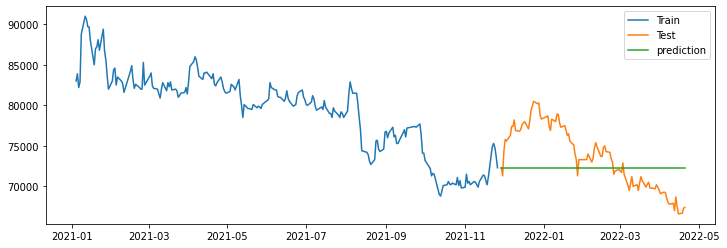

In [10]:
sam = fdr.DataReader(''.join(symbol.values), '2021-01-01','2022-04-20')
# sam.plot()
fig, axes = plt.subplots(figsize=(12, 4))
plt.plot(y_train, label='Train')
plt.plot(y_test, label= 'Test')
plt.plot(predict, label='prediction')
plt.legend()
plt.show()

In [11]:
def forcast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    
    return (fc.tolist()[0], np.asarray(conf_int).tolist()[0])
    

In [12]:
forcast_one_step()

(72300.0, [70148.77769092662, 74451.22230907338])

In [13]:
forcast_list = []
y_pred = []
pred_upper = []
pred_lower = []

for i in y_test:
    fc, conf = forcast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    
    model.update(i)

In [14]:
pd.DataFrame({'test': y_test, 'y_pred' : y_pred})

,test,y_pred
Date,,
2021-11-29,72300,72300.0
2021-11-30,71300,72300.0
2021-12-01,74400,71300.0
2021-12-02,75800,74400.0
2021-12-03,75600,75800.0
...,...,...
2022-04-14,67500,68700.0
2022-04-15,66600,67500.0
2022-04-18,66700,66600.0


In [18]:
import plotly.graph_objects as go

go

<module 'plotly.graph_objects' from 'C:\\Users\\spaceastonomy\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\plotly\\graph_objects\\__init__.py'>

In [22]:
import plotly.graph_objects as go
fig = go.Figure([
    go.Scatter(x=y_train.index , y=y_train, name='Train', mode='lines',line=dict(color='royalblue')),
 #테스트 데이터
go.Scatter(x=y_test.index , y=y_test, name='Train', mode='lines',line=dict(color='rgb[0, 0, 30, 0.5')),
#predict 데이터
go.Scatter(x=y_test.index , y=y_pred, name='Train', mode='lines',line=dict(color='red', dash = 'dot', width=3)),
#신뢰구간
go.Scatter(x=y_test.index.tolist() + y_test.index[:: -1].tolist(), 
           y= pred_upper + pred_lower[:: -1],
           fill = 'toself', 
           fillcolor = 'rgba(0, 0, 30, o.1)',
           line={'color' : 'rgba(0,0,0,0)'},
           hoverinfo = "skip",
           showlegend = True
           )
])

fig.update_layout(height=400 , width=1000, title_text="ARIMA(0,1,0)")
fig.show()

ValueError: 
    Invalid value of type 'builtins.str' received for the 'color' property of scatter.line
        Received value: 'rgb[0, 0, 30, 0.5'

    The 'color' property is a color and may be specified as:
      - A hex string (e.g. '#ff0000')
      - An rgb/rgba string (e.g. 'rgb(255,0,0)')
      - An hsl/hsla string (e.g. 'hsl(0,100%,50%)')
      - An hsv/hsva string (e.g. 'hsv(0,100%,100%)')
      - A named CSS color:
            aliceblue, antiquewhite, aqua, aquamarine, azure,
            beige, bisque, black, blanchedalmond, blue,
            blueviolet, brown, burlywood, cadetblue,
            chartreuse, chocolate, coral, cornflowerblue,
            cornsilk, crimson, cyan, darkblue, darkcyan,
            darkgoldenrod, darkgray, darkgrey, darkgreen,
            darkkhaki, darkmagenta, darkolivegreen, darkorange,
            darkorchid, darkred, darksalmon, darkseagreen,
            darkslateblue, darkslategray, darkslategrey,
            darkturquoise, darkviolet, deeppink, deepskyblue,
            dimgray, dimgrey, dodgerblue, firebrick,
            floralwhite, forestgreen, fuchsia, gainsboro,
            ghostwhite, gold, goldenrod, gray, grey, green,
            greenyellow, honeydew, hotpink, indianred, indigo,
            ivory, khaki, lavender, lavenderblush, lawngreen,
            lemonchiffon, lightblue, lightcoral, lightcyan,
            lightgoldenrodyellow, lightgray, lightgrey,
            lightgreen, lightpink, lightsalmon, lightseagreen,
            lightskyblue, lightslategray, lightslategrey,
            lightsteelblue, lightyellow, lime, limegreen,
            linen, magenta, maroon, mediumaquamarine,
            mediumblue, mediumorchid, mediumpurple,
            mediumseagreen, mediumslateblue, mediumspringgreen,
            mediumturquoise, mediumvioletred, midnightblue,
            mintcream, mistyrose, moccasin, navajowhite, navy,
            oldlace, olive, olivedrab, orange, orangered,
            orchid, palegoldenrod, palegreen, paleturquoise,
            palevioletred, papayawhip, peachpuff, peru, pink,
            plum, powderblue, purple, red, rosybrown,
            royalblue, rebeccapurple, saddlebrown, salmon,
            sandybrown, seagreen, seashell, sienna, silver,
            skyblue, slateblue, slategray, slategrey, snow,
            springgreen, steelblue, tan, teal, thistle, tomato,
            turquoise, violet, wheat, white, whitesmoke,
            yellow, yellowgreen

In [ ]:
sam = fdr.DataReader(''.join(symbol.values), start='2021-01-01', end='2022-04-10')
# fdr.DataReader(''.join(symbol.values), '2021-01-01~2021-12-31')
sam_1 = sam['Close'].plot()
plt.show(sam_1)


In [ ]:
5조 : 이지현, 이명희, 전유석, 황윤재

-------
5조 

------
주제 : 주가종가예측 
    
    * 기존 은행, 인터넷 은행
    * 이론적인 것을 어떻게 구성할 것인가? 
    * 역사는 반복 된다. 
    * 배아프다.
    * 가즈아
    * 초콜릿
    * 배깅 
    * 시계
    * 자동화
    * 메타버스
    * 거래량
    * 산업군의 다양성 
    * 충격
    * 넷플릭스
    * 오징어게임
    * 네이버
    * 코로나 전 후 변동성
    * 포스트 코로나 
    * 체계적 오류 
    * 머신 러닝
    * 앤데믹
    * 인원수 조절
    * 데이터 누적 기간
    * 기대 
    * 원자재, 물가, 농산물, 밀
    * 시가 총액
    * 코스피 100
    * 우크라이나 전쟁, 
    * 러시아, 우크라이나, 밀 가격
    * 금 
    * 오뚜기
    * 환경주 
    * 천연가스
    * 온난화
    * 금리
    * 원유가
    * 우유
    * 비대면, 대면
    * 코로나가 없었다면, 회귀하게 된다면
    * 거품, 수출 
    * 주가 출렁임
    * 박스권 시작과 끝
    * 환율
    * 곡물회사 - 


------

* 역할 나누기
    * 전처리, 탐색적 데이터분석, 기본적 분석(경제, 도메인), 기술적분석(차트), 머신러닝
    * 회귀분석 : 시각화() 
    * 아리마모델 : 
    * 밀 etf 주식 종가, 오뚜기 주식 종가, 




김정훈 : 금융, 취업
황윤재 : 데이터분석, 인사이트, 
이명희 : 전체적 빅데이터, 비영리 단체(회계), 투자 
이지현 : 콘텐츠, 금융투자
전유석 : 빅데이터, 여러 데이터를 다루기, 